In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [1]:
import os
os.environ['PYSPARK_PYTHON'] = '/home/luban/anaconda3/envs/python36/bin/python'
import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *

app_name = 'xuyunqing_juypter'
conf = (SparkConf().setAppName(app_name)
        .set('spark.master', 'yarn')
        .set('spark.submit.deployMode', 'client')
        .set('spark.driver.memory',                  '20g')
        .set('spark.executor.memory',                '8g')
        .set('spark.dynamicAllocation.minExecutors', '2')
        .set('spark.dynamicAllocation.maxExecutors', '200')
        .set('spark.yarn.queue',                     'root.pricing_dape_core_service_prod')
        .set('spark.ui.port','8060')
        .set('spark.executor.memoryOverhead','4096')
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set('spark.driver.allowMultipleContexts', 'True')
        .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2')
        .set('spark.pyspark.driver.python',          '/home/luban/anaconda3/envs/python36/bin/python')
        .set('spark.pyspark.python', './python3.6.2/bin/python')
        .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
        )
spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
sc = spark.sparkContext

from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
hc = HiveContext(sc)

In [2]:
sql = \
'''
with tmp_usr_data as 
(
    select  t1.group_name
            ,t1.passenger_id as pid
            ,t1.city_id
            ,t1.dt
            ,if(t1.group_name like '%_blank%', 1, 0) as is_blank
            ,t1.exp_name
    from    (
        select  s1.passenger_id
                ,case   when s2.group_flag = 'joint' and group_name like '%_blank%' then 'rgroup_joint_blank'
                        when s2.group_flag = 'joint' then 'rgroup_joint_exp'
                 end as group_name
                ,s1.city_id
                ,s1.dt
                ,s2.group_flag as exp_name
        from    (
            select  passenger_id
                    ,group_name
                    ,city_id
                    ,dt
                    ,current_product_type
                    ,layer_id
            from    dd_cdm.dwd_trip_trd_price_exppas_info_df
            where   dt between '{start_date}' and '{end_date}'
              and   passenger_id is not null
              and   (
                        current_product_type in (206, 314)
                    )
              and   dt >= '2023-01-07'
              and city_id in ({city_list})
        ) s1
        join    (
            select  dt
                    ,group_flag
                    ,layer_id
            from    (
                select  
                        dt
                        ,'joint' as group_flag
                        ,layer_id
                from    dd_cdm.dwd_trip_trd_price_exppas_flow_layer_info_di
                where   
                    dt between '{start_date}' and '{end_date}'
                    and   layer_name regexp '快车特惠|快特'
                  and   layer_name regexp '双非' -- 取双非城市
            ) r1
            group by 1, 2,3
        ) s2
        on      s1.layer_id = s2.layer_id and s1.dt = s2.dt
        group by 1, 2, 3, 4, 5
    ) t1
)
,tmp_base_di as 
(	-- 短期实验人群 + 行为信息
    select  t1.pid
            ,t1.city_id
            ,t1.dt
            ,t1.exp_name
            ,t1.group_name
            ,t1.is_blank
            ,t3.product_line
            ,t3.gmv
            ,t3.subsidy_hufan
            ,t3.subsidy_c
            ,t3.subsidy_coupon
            ,t3.bubble_cnt
            ,t3.compete_call_cnt
            ,t3.objective_call_cnt
    from    tmp_usr_data t1
    left join (
        select  product_line
                ,city_id
                ,dt
                ,passenger_id
                ,gmv
                ,subsidy_hufan
                ,subsidy_c
                ,subsidy_coupon
                ,bubble_cnt
                ,compete_call_cnt
                ,objective_call_cnt
        from    mp_data.dwm_trip_trd_psg_core_di
        where   dt between '{start_date}' and '{end_date}'
          and   product_line = '新泛快'
          and   city_id in ({city_list})
    ) t3
    on      t1.pid = t3.passenger_id
      and   t1.city_id = t3.city_id
      and   t1.dt = t3.dt
)
select  group_name
        ,city_id 
        ,dt
        ,is_blank
        ,count(distinct city_id, pid) as group_usr_num --分组去重冒泡乘客数
        ,sum(gmv) as gmv
        ,sum(subsidy_hufan) as subsidy_hufan
        ,sum(subsidy_coupon) as subsidy_coupon
        ,sum(subsidy_c) as subsidy_c
        ,sum(bubble_cnt) as bubble_cnt
        ,sum(compete_call_cnt) as compete_call_cnt
        ,sum(objective_call_cnt) as objective_call_cnt
from    (
    select  exp_name
            ,group_name
            ,is_blank
            ,pid
            ,product_line
            ,city_id
            ,dt
            ,nvl(gmv, 0) as gmv
            ,nvl(subsidy_hufan, 0) as subsidy_hufan
            ,nvl(subsidy_c, 0) as subsidy_c
            ,nvl(subsidy_coupon, 0) as subsidy_coupon
            ,nvl(bubble_cnt, 0) as bubble_cnt
            ,nvl(compete_call_cnt, 0) as compete_call_cnt
            ,nvl(objective_call_cnt, 0) as objective_call_cnt
    from    tmp_base_di
    union all -- 各层级实验组打包(exp + stg)
    select  exp_name
            ,concat_ws('_', 'rgroup', split(group_name, '_')[1], 'exp_pack') as group_name
            ,is_blank
            ,pid
            ,product_line
            ,city_id
            ,dt
            ,nvl(gmv, 0) as gmv
            ,nvl(subsidy_hufan, 0) as subsidy_hufan
            ,nvl(subsidy_c, 0) as subsidy_c
            ,nvl(subsidy_coupon, 0) as subsidy_coupon
            ,nvl(bubble_cnt, 0) as bubble_cnt
            ,nvl(compete_call_cnt, 0) as compete_call_cnt
            ,nvl(objective_call_cnt, 0) as objective_call_cnt
    from    tmp_base_di
    where   is_blank = 0	-- 排除空白组
      and   group_name <> 'rgroup_exp_multi_pack'	-- 排除掉整体流量组打包
) s1
group by group_name, is_blank, city_id, dt
'''.format(start_date='2023-04-01', end_date='2023-04-19', 
           city_list='1,7,8,9,13,14,15,16,20,21,22,23,25,26,28,30,32,33,34,35,36,38,39,40,42,43,44,45,46,47,49,52,53,54,55,56,57,58,59,60,61,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,82,85,86,88,89,91,96,98,99,102,103,104,105,107,109,116,117,118,119,120,122,124,125,126,127,128,129,130,131,132,133,135,137,138,140,141,144,145,146,148,149,150,153,154,156,157,158,160,162,163,164,166,168,169,171,174,175,177,178,179,180,181,185,190,191,192,193,194,195,196,197,198,199,200,201,202,203,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,222,224,225,226,228,230,231,232,238,239,242,243,246,247,248,249,251,252,253,254,255,256,258,260,261,262,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,280,281,282,283,284,286,287,290,291,292,293,294,295,296,297,298,299,300,301,302,303,305,306,308,309,310,311,312,313,314,315,316,317,318,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,359,360,361,362,363,364,365,366,367,368,369,370,371,372')


In [ ]:
df = spark.sql(sql).toPandas()
df

In [3]:
df = pd.read_csv('双非ROI口径_202304.csv')

# 筛选条件：2023年4月份，双非城市，GMV不等于0，既有实验组又有空白组

In [4]:
# 取出实验组和空白组
df1 = df.query("group_name in ('rgroup_joint_exp_pack','rgroup_joint_blank') ")

# 取出gmv大于0的样本
df1 = df1[df1['fk_gmv'] > 0]

# 取出既有实验组又有空白组的(城市, 日期)
temp = df1[['is_blank', 'city_id', 'dt']].groupby(['city_id', 'dt']).count().reset_index()
temp = temp[temp['is_blank'] == 2]
df1 = pd.merge(temp[['city_id', 'dt']], df1, how='left', on=['city_id', 'dt'])

df1['fk_gmv'] = df1['gmv']/df1['group_usr_num'] # 人均gmv
df1['fk_subsidy_c'] = df1['subsidy_c']/df1['group_usr_num'] # 人均c补
df1['fk_subsidy_hufan'] = df1['subsidy_hufan']/df1['group_usr_num'] #人均呼返

df1['fk_crate'] = df1['fk_subsidy_c']/df1['fk_gmv'] # 泛快c补率
df1['fk_hf_crate'] = df1['fk_subsidy_hufan']/df1['fk_gmv'] # 泛快呼返补贴率
df1['fk_bg_crate'] = (df1['fk_subsidy_c'] - df1['fk_subsidy_hufan'])/df1['fk_gmv']

df1

,city_id,dt,Unnamed: 0,group_name,is_blank,group_usr_num,gmv,subsidy_hufan,subsidy_coupon,subsidy_c,bubble_cnt,compete_call_cnt,objective_call_cnt,fk_gmv,fk_subsidy_c,fk_subsidy_hufan,fk_crate,fk_hf_crate,fk_bg_crate
0,1,2023-04-01,9451,rgroup_joint_exp_pack,0,1176468,29296355.77,739380.06,2419780.35,2.629900e+06,5042490.0,1410529.0,1091681.0,24.901957,2.235420,0.628474,0.089769,0.025238,0.064531
1,1,2023-04-01,12746,rgroup_joint_blank,1,11964,280638.78,62.77,17662.64,1.925415e+04,49920.0,14055.0,10826.0,23.456936,1.609340,0.005247,0.068608,0.000224,0.068385
2,1,2023-04-02,2529,rgroup_joint_blank,1,10295,250903.31,85.85,16918.18,1.849042e+04,41281.0,11176.0,9020.0,24.371375,1.796058,0.008339,0.073695,0.000342,0.073353
3,1,2023-04-02,2931,rgroup_joint_exp_pack,0,1016482,26620857.53,490979.13,2078050.57,2.303802e+06,4150447.0,1126393.0,910298.0,26.189207,2.266446,0.483018,0.086541,0.018443,0.068098
4,1,2023-04-03,5213,rgroup_joint_blank,1,17839,485819.26,4555.47,22673.00,2.622816e+04,74796.0,20401.0,15995.0,27.233548,1.470271,0.255366,0.053987,0.009377,0.044611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8871,372,2023-04-17,13562,rgroup_joint_exp_pack,0,4302,37414.95,744.92,2194.68,2.408090e+03,17794.0,4907.0,4145.0,8.697106,0.559761,0.173157,0.064362,0.019910,0.044452
8872,372,2023-04-18,8789,rgroup_joint_exp_pack,0,3955,37008.53,935.33,1982.20,2.183180e+03,16067.0,4525.0,3787.0,9.357403,0.552005,0.236493,0.058991,0.025273,0.033718
8873,372,2023-04-18,13468,rgroup_joint_blank,1,135,1173.42,0.00,39.68,4.166000e+01,630.0,169.0,150.0,8.692000,0.308593,0.000000,0.035503,0.000000,0.035503
8874,372,2023-04-19,2922,rgroup_joint_exp_pack,0,4105,35971.29,777.97,1903.71,2.124300e+03,16962.0,4730.0,3941.0,8.762799,0.517491,0.189518,0.059055,0.021628,0.037428


# 空白组背景C补率占比 = 空白组背景C补率 / (空白组背景C补率 + 实验组背景C补率)

In [5]:
temp = df1[['fk_bg_crate', 'city_id', 'dt']].groupby(['city_id', 'dt']).sum().reset_index().rename(columns={'fk_bg_crate':'fk_bg_crate_sum'})
df2 = pd.merge(df1[df1['is_blank'] == 1][['fk_bg_crate', 'city_id', 'dt']], temp, how='left', on=['city_id', 'dt'])
df2['fk_bg_crate_blank_ratio'] = df2['fk_bg_crate']/df2['fk_bg_crate_sum']
df2 = df2[['city_id', 'dt', 'fk_bg_crate_blank_ratio']].sort_values(['city_id', 'dt'])
df2

,city_id,dt,fk_bg_crate_blank_ratio
0,1,2023-04-01,0.514497
1,1,2023-04-02,0.518577
2,1,2023-04-03,0.505853
3,1,2023-04-04,0.507010
4,1,2023-04-05,0.506239
...,...,...,...
4433,372,2023-04-15,0.460757
4434,372,2023-04-16,0.474255
4435,372,2023-04-17,0.464519
4436,372,2023-04-18,0.512895


# 按城市和日期排序的空白组背景C补率占比散点图

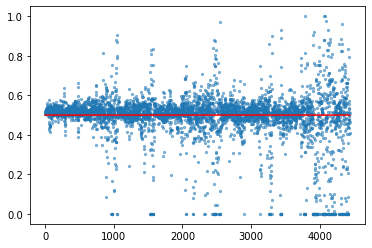

In [6]:
plt.scatter(np.arange(df2.shape[0]), df2['fk_bg_crate_blank_ratio'], s=5, alpha=0.5)
plt.plot(np.arange(df2.shape[0]), 0*np.arange(df2.shape[0]) + 0.5, color='red')

# 筛选条件：两组背景C补率占比都不等于0

In [7]:
df3 = df2[(df2['fk_bg_crate_blank_ratio'] != 0) & (df2['fk_bg_crate_blank_ratio'] != 1) & (~df2['fk_bg_crate_blank_ratio'].isna())]
df3

,city_id,dt,fk_bg_crate_blank_ratio
0,1,2023-04-01,0.514497
1,1,2023-04-02,0.518577
2,1,2023-04-03,0.505853
3,1,2023-04-04,0.507010
4,1,2023-04-05,0.506239
...,...,...,...
4433,372,2023-04-15,0.460757
4434,372,2023-04-16,0.474255
4435,372,2023-04-17,0.464519
4436,372,2023-04-18,0.512895


# 按城市和日期排序的空白组背景C补率占比散点图（两组背景C补率占比都不等于0）

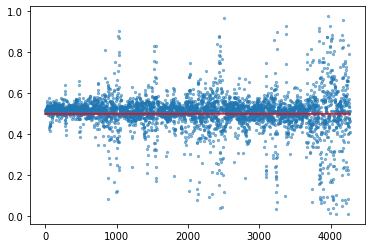

In [8]:
plt.scatter(np.arange(df3.shape[0]), df3['fk_bg_crate_blank_ratio'], s=5, alpha=0.5)
plt.plot(np.arange(df3.shape[0]), 0*np.arange(df3.shape[0]) + 0.5, color='red')

# 生成城市和日期的哑变量（两组背景C补率占比都不等于0）

In [9]:
df4 = pd.merge(df3[['city_id', 'dt']], df1[['fk_bg_crate', 'is_blank', 'city_id', 'dt']], how='left', on=['city_id', 'dt'])
df4 = pd.get_dummies(df4, columns=['city_id', 'dt'], drop_first=True)
df4

,fk_bg_crate,is_blank,city_id_7,city_id_8,city_id_9,city_id_13,city_id_14,city_id_15,city_id_16,city_id_20,...,dt_2023-04-10,dt_2023-04-11,dt_2023-04-12,dt_2023-04-13,dt_2023-04-14,dt_2023-04-15,dt_2023-04-16,dt_2023-04-17,dt_2023-04-18,dt_2023-04-19
0,0.064531,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.068385,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.073353,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.068098,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.044611,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8533,0.044452,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8534,0.033718,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8535,0.035503,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8536,0.037428,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# （两组背景C补率占比都不等于0）
# 回归：因变量为背景C补率，解释变量为是否是空白组，固定效应为城市和日期
# 结果：解释变量系数在95%水平下显著，说明是否是空白组对背景C补率有显著的影响

In [10]:
X = df4.loc[:, 'is_blank':]
y = df4['fk_bg_crate']
X = sm.add_constant(X) #添加常数项
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fk_bg_crate   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     29.61
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:39:07   Log-Likelihood:                 18126.
No. Observations:                8538   AIC:                        -3.571e+04
Df Residuals:                    8266   BIC:                        -3.379e+04
Df Model:                         271                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0635      0.005     12.732      0.000       0.054       0.073
is_blank          0.0074      0.001     11.666      0.000       0.006       0.009
city_id_7         0.0376      0.007      5.566      0.000       0.024       0.051
city_id_8         0.0200      0.007      2.967      0.003       0.007       0.033
city_id_9         0.0178      0.008      2.194      0.028       0.002       0.034
city_id_13        0.0069      0.007      1.027      0.305      -0.006       0.020
city_id_14        0.0195      0.007      2.892      0.004       0.006       0.033
city_id_15        0.0067      0.007      0.996      0.319      -0.007       0.020
city_id_16        0.0177      0.007      2.625      0.009       0.004       0.031
city_id_20       -0.0077      0.007     -1.136      0.256      -0.021       0.006
city_id_21       -0.0102      0.007     -1.506      0.132      -0.023       0.003
city_id_22        0.0211      0.007      3.127      0.002       0.008       0.034
city_id_23       -0.0016      0.007     -0.240      0.810      -0.015       0.012
city_id_25        0.0228      0.007      3.374      0.001       0.010       0.036
city_id_26        0.0193      0.007      2.855      0.004       0.006       0.033
city_id_28        0.0072      0.007      1.062      0.288      -0.006       0.020
city_id_30        0.0021      0.007      0.313      0.754      -0.011       0.015
city_id_32        0.0094      0.007      1.385      0.166      -0.004       0.023
city_id_33        0.0020      0.007      0.293      0.770      -0.011       0.015
city_id_34        0.0157      0.007      2.319      0.020       0.002       0.029
city_id_35       -0.0068      0.007     -1.003      0.316      -0.020       0.006
city_id_36       -0.0084      0.007     -1.241      0.215      -0.022       0.005
city_id_38        0.0167      0.007      2.468      0.014       0.003       0.030
city_id_39        0.0038      0.007      0.569      0.569      -0.009       0.017
city_id_40        0.0024      0.007      0.359      0.719      -0.011       0.016
city_id_42        0.0284      0.007      4.201      0.000       0.015       0.042
city_id_43       -0.0009      0.007     -0.136      0.891      -0.014       0.012
city_id_44        0.0027      0.007      0.404      0.686      -0.011       0.016
city_id_45        0.0057      0.007      0.848      0.396      -0.008       0.019
city_id_46       -0.0034      0.007     -0.501      0.617      -0.017       0.010
city_id_47        0.0019      0.007      0.277      0.782      -0.011       0.015
city_id_49       -0.0016      0.007     -0.236      0.813      -0.015       0.012
city_id_52        0.0176      0.007      2.602      0.009       0.004       0.031
city_id_53        0.0023      0.007      0.344      0.731      -0.011       0.016
city_id_54        0.0214      0.007      3.175   

# 生成城市和日期的哑变量（空白组背景C补率占比不等于0）

In [11]:
temp = df1[['fk_bg_crate', 'city_id', 'dt']].groupby(['city_id', 'dt']).sum().reset_index().rename(columns={'fk_bg_crate':'fk_bg_crate_sum'})
df5 = pd.merge(df1[['fk_bg_crate', 'is_blank', 'city_id', 'dt']], temp, how='left', on=['city_id', 'dt'])
df5['fk_bg_crate_ratio'] = df5['fk_bg_crate']/df5['fk_bg_crate_sum']
df5 = pd.merge(df3[['city_id', 'dt']], df5[['fk_bg_crate_ratio', 'is_blank', 'city_id', 'dt']], how='left', on=['city_id', 'dt'])
df5 = pd.get_dummies(df5, columns=['city_id', 'dt'], drop_first=True)
df5

,fk_bg_crate_ratio,is_blank,city_id_7,city_id_8,city_id_9,city_id_13,city_id_14,city_id_15,city_id_16,city_id_20,...,dt_2023-04-10,dt_2023-04-11,dt_2023-04-12,dt_2023-04-13,dt_2023-04-14,dt_2023-04-15,dt_2023-04-16,dt_2023-04-17,dt_2023-04-18,dt_2023-04-19
0,0.485503,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.514497,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.518577,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.481423,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.505853,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8533,0.535481,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8534,0.487105,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8535,0.512895,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8536,0.588178,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# （空白组背景C补率占比不等于0）
# 回归：因变量为背景C补率占比，解释变量为是否是空白组，固定效应为城市和日期
# 结果：解释变量系数在95%水平下显著，说明是否是空白组对背景C补率占比有显著的影响

In [12]:
X = df5.loc[:, 'is_blank':]
y = df5['fk_bg_crate_ratio']
X = sm.add_constant(X) #添加常数项
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      fk_bg_crate_ratio   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2101
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               1.00
Time:                        15:39:13   Log-Likelihood:                 8424.1
No. Observations:                8538   AIC:                        -1.630e+04
Df Residuals:                    8266   BIC:                        -1.439e+04
Df Model:                         271                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4925      0.016     31.713      0.000       0.462       0.523
is_blank          0.0150      0.002      7.546      0.000       0.011       0.019
city_id_7     -1.771e-14      0.021  -8.42e-13      1.000      -0.041       0.041
city_id_8      3.539e-14      0.021   1.68e-12      1.000      -0.041       0.041
city_id_9     -1.435e-14      0.025  -5.66e-13      1.000      -0.050       0.050
city_id_13     2.845e-14      0.021   1.35e-12      1.000      -0.041       0.041
city_id_14    -6.504e-15      0.021  -3.09e-13      1.000      -0.041       0.041
city_id_15     2.324e-15      0.021    1.1e-13      1.000      -0.041       0.041
city_id_16     2.897e-14      0.021   1.38e-12      1.000      -0.041       0.041
city_id_20     5.666e-14      0.021   2.69e-12      1.000      -0.041       0.041
city_id_21     1.937e-14      0.021   9.21e-13      1.000      -0.041       0.041
city_id_22     2.358e-14      0.021   1.12e-12      1.000      -0.041       0.041
city_id_23     1.102e-14      0.021   5.24e-13      1.000      -0.041       0.041
city_id_25     4.588e-14      0.021   2.18e-12      1.000      -0.041       0.041
city_id_26    -1.488e-14      0.021  -7.07e-13      1.000      -0.041       0.041
city_id_28    -1.496e-14      0.021  -7.11e-13      1.000      -0.041       0.041
city_id_30     1.916e-14      0.021   9.11e-13      1.000      -0.041       0.041
city_id_32    -1.323e-14      0.021  -6.29e-13      1.000      -0.041       0.041
city_id_33     3.629e-14      0.021   1.73e-12      1.000      -0.041       0.041
city_id_34    -3.409e-14      0.021  -1.62e-12      1.000      -0.041       0.041
city_id_35     8.742e-15      0.021   4.16e-13      1.000      -0.041       0.041
city_id_36     4.508e-14      0.021   2.14e-12      1.000      -0.041       0.041
city_id_38     3.943e-14      0.021   1.87e-12      1.000      -0.041       0.041
city_id_39     3.931e-14      0.021   1.87e-12      1.000      -0.041       0.041
city_id_40     5.215e-14      0.021   2.48e-12      1.000      -0.041       0.041
city_id_42    -1.019e-14      0.021  -4.84e-13      1.000      -0.041       0.041
city_id_43    -1.671e-14      0.021  -7.94e-13      1.000      -0.041       0.041
city_id_44     1.227e-14      0.021   5.83e-13      1.000      -0.041       0.041
city_id_45     3.049e-14      0.021   1.45e-12      1.000      -0.041       0.041
city_id_46       1.3e-14      0.021   6.18e-13      1.000      -0.041       0.041
city_id_47     2.637e-14      0.021   1.25e-12      1.000      -0.041       0.041
city_id_49     1.302e-15      0.021   6.19e-14      1.000      -0.041       0.041
city_id_52     1.977e-14      0.021    9.4e-13      1.000      -0.041       0.041
city_id_53     1.822e-14      0.021   8.66e-13      1.000      -0.041       0.041
city_id_54     1.685e-14      0.021   8.01e-13   

(array([  1.,   1.,   1.,   1.,   2.,   4.,   6.,  12.,  24.,  47.,  67.,
         82.,  69.,  90., 113., 150., 154., 201., 211., 232., 248., 326.,
        314., 328., 328., 305., 353., 291., 283., 137.]),
 array([0.07476636, 0.10560392, 0.13644148, 0.16727904, 0.19811661,
        0.22895417, 0.25979173, 0.2906293 , 0.32146686, 0.35230442,
        0.38314199, 0.41397955, 0.44481711, 0.47565467, 0.50649224,
        0.5373298 , 0.56816736, 0.59900493, 0.62984249, 0.66068005,
        0.69151761, 0.72235518, 0.75319274, 0.7840303 , 0.81486787,
        0.84570543, 0.87654299, 0.90738056, 0.93821812, 0.96905568,
        0.99989324]),
 <BarContainer object of 30 artists>)

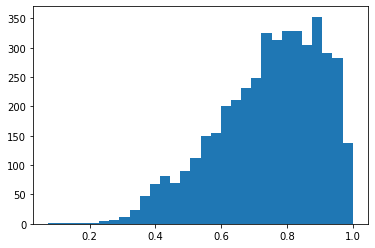

In [31]:
df1['fk_bg_crate_rate'] = df1['fk_bg_crate']/df1['fk_crate']
df1 = df1.sort_values(['city_id', 'dt', 'is_blank'])
plt.hist(df1[(df1['is_blank'] == 0) & (df1['fk_bg_crate_rate'] < 1)]['fk_bg_crate_rate'], bins=30)

In [14]:
df1['fk_bg_crate_rate'].describe()

count    8705.000000
mean        0.863694
std         0.168502
min         0.000000
25%         0.762060
50%         0.948005
75%         0.999258
max         1.000000
Name: fk_bg_crate_rate, dtype: float64

In [15]:
df6 = pd.merge(df3[['city_id', 'dt']], df1, how='left', on=['city_id', 'dt'])
df6_blank = df6[df6['is_blank'] == 1][['city_id', 'dt','fk_gmv', 'fk_subsidy_c', 'fk_subsidy_hufan']].sort_values(['city_id', 'dt'])
df6_expr = df6[df6['is_blank'] == 0][['city_id', 'dt','fk_gmv', 'fk_subsidy_c', 'fk_subsidy_hufan']].sort_values(['city_id', 'dt'])
df7 = df6_blank[['city_id', 'dt']]
df7['delta_fk_gmv'] = df6_expr['fk_gmv'].values - df6_blank['fk_gmv'].values
df7['delta_fk_subsidy_c'] = df6_expr['fk_subsidy_c'].values - df6_blank['fk_subsidy_c'].values
df7['delta_fk_subsidy_hufan'] = df6_expr['fk_subsidy_hufan'].values - df6_blank['fk_subsidy_hufan'].values
df7['delta_subsidy_bias'] = df7['delta_fk_subsidy_hufan'] - df7['delta_fk_subsidy_c']
df7['roi_c'] = df7['delta_fk_gmv']/df7['delta_fk_subsidy_c']
df7['roi_hufan'] = df7['delta_fk_gmv']/df7['delta_fk_subsidy_hufan']
df7['roi_bias'] = df7['roi_hufan'] - df7['roi_c']
df7

/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,city_id,dt,delta_fk_gmv,delta_fk_subsidy_c,delta_fk_subsidy_hufan,delta_subsidy_bias,roi_c,roi_hufan,roi_bias
1,1,2023-04-01,1.445021,0.626080,0.623228,-0.002852,2.308047,2.318608,0.010562
3,1,2023-04-02,1.817832,0.470388,0.474679,0.004291,3.864539,3.829602,-0.034937
5,1,2023-04-03,-2.133089,0.750145,0.871216,0.121071,-2.843569,-2.448404,0.395165
7,1,2023-04-04,-0.613058,0.052332,0.101653,0.049322,-11.714874,-6.030874,5.683999
9,1,2023-04-05,0.415355,0.230861,0.238243,0.007381,1.799155,1.743412,-0.055743
...,...,...,...,...,...,...,...,...,...
8529,372,2023-04-15,0.298147,0.114181,0.035702,-0.078479,2.611185,8.350992,5.739806
8531,372,2023-04-16,0.366352,0.109969,0.050306,-0.059663,3.331401,7.282474,3.951072
8533,372,2023-04-17,0.868968,0.257899,0.173157,-0.084742,3.369419,5.018392,1.648973
8535,372,2023-04-18,0.665403,0.243412,0.236493,-0.006919,2.733645,2.813627,0.079982


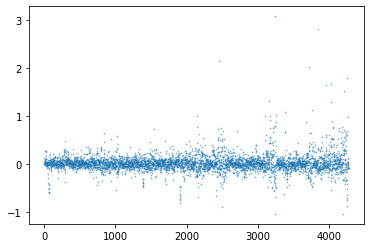

In [21]:
plt.scatter(np.arange(df7.shape[0]), df7['delta_subsidy_bias'], s=0.5, alpha=0.5)

In [43]:
temp = df7[(df7['delta_fk_subsidy_c'] > 0) & (df7['delta_fk_subsidy_hufan'] > 0)]
temp_hufan = temp[['city_id', 'dt', 'delta_fk_subsidy_hufan']].rename(columns={'delta_fk_subsidy_hufan':'delta_subsidy'})
temp_hufan['is_hufan'] = 1
temp_c = temp[['city_id', 'dt', 'delta_fk_subsidy_c']].rename(columns={'delta_fk_subsidy_c':'delta_subsidy'})
temp_c['is_hufan'] = 0
df8 = pd.concat((temp_hufan, temp_c))
df8 = pd.get_dummies(df8, columns=['city_id', 'dt'], drop_first=True)
X = df8.loc[:, 'is_hufan':]
y = df8['delta_subsidy']
X = sm.add_constant(X) #添加常数项
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_subsidy   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     35.17
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:56:44   Log-Likelihood:                 394.93
No. Observations:                7284   AIC:                            -269.9
Df Residuals:                    7024   BIC:                             1522.
Df Model:                         259                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6065      0.040     15.180      0.000       0.528       0.685
is_hufan         -0.0139      0.005     -2.541      0.011      -0.025      -0.003
city_id_7         0.3976      0.054      7.426      0.000       0.293       0.503
city_id_8        -0.3053      0.054     -5.702      0.000      -0.410      -0.200
city_id_9         0.1370      0.065      2.123      0.034       0.011       0.264
city_id_13        0.2606      0.054      4.867      0.000       0.156       0.366
city_id_14       -0.2888      0.054     -5.393      0.000      -0.394      -0.184
city_id_15        0.3254      0.054      6.076      0.000       0.220       0.430
city_id_16       -0.2187      0.054     -4.085      0.000      -0.324      -0.114
city_id_20        0.0778      0.054      1.453      0.146      -0.027       0.183
city_id_21       -0.0920      0.054     -1.719      0.086      -0.197       0.013
city_id_22       -0.0728      0.054     -1.360      0.174      -0.178       0.032
city_id_23        0.1851      0.054      3.456      0.001       0.080       0.290
city_id_25       -0.2770      0.054     -5.173      0.000      -0.382      -0.172
city_id_26       -0.0802      0.054     -1.497      0.134      -0.185       0.025
city_id_28       -0.3568      0.054     -6.663      0.000      -0.462      -0.252
city_id_30       -0.3368      0.063     -5.382      0.000      -0.459      -0.214
city_id_32        0.0406      0.054      0.757      0.449      -0.064       0.146
city_id_33        0.0820      0.054      1.531      0.126      -0.023       0.187
city_id_34        0.0982      0.054      1.833      0.067      -0.007       0.203
city_id_35        0.0629      0.054      1.174      0.240      -0.042       0.168
city_id_36        0.1632      0.054      3.047      0.002       0.058       0.268
city_id_38        0.2311      0.054      4.316      0.000       0.126       0.336
city_id_39        0.0775      0.054      1.447      0.148      -0.028       0.182
city_id_40        0.1490      0.054      2.783      0.005       0.044       0.254
city_id_42       -0.0507      0.054     -0.948      0.343      -0.156       0.054
city_id_43       -0.5491      0.059     -9.239      0.000      -0.666      -0.433
city_id_44       -0.2835      0.054     -5.295      0.000      -0.388      -0.179
city_id_45        0.0890      0.054      1.662      0.097      -0.016       0.194
city_id_46       -0.1537      0.054     -2.870      0.004      -0.259      -0.049
city_id_47        0.2268      0.054      4.235      0.000       0.122       0.332
city_id_49       -0.1608      0.054     -3.003      0.003      -0.266      -0.056
city_id_52       -0.1765      0.055     -3.203      0.001      -0.285      -0.068
city_id_53       -0.3618      0.054     -6.757      0.000      -0.467      -0.257
city_id_54       -0.2056      0.054     -3.839   

In [44]:
temp = df7[(df7['delta_fk_subsidy_c'] > 0) & (df7['delta_fk_subsidy_hufan'] > 0)]
temp_hufan = temp[['city_id', 'dt', 'delta_fk_subsidy_hufan']].rename(columns={'delta_fk_subsidy_hufan':'delta_subsidy'})
temp_hufan['is_hufan'] = 1
temp_c = temp[['city_id', 'dt', 'delta_fk_subsidy_c']].rename(columns={'delta_fk_subsidy_c':'delta_subsidy'})
temp_c['is_hufan'] = 0
df9 = pd.concat((temp_hufan, temp_c))
df9 = pd.get_dummies(df9, columns=['city_id', 'dt'], drop_first=True)
X = df9.loc[:, 'is_hufan':]
y = np.log(df9['delta_subsidy'])
X = sm.add_constant(X) #添加常数项
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delta_subsidy   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     39.08
Date:                Fri, 21 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:57:14   Log-Likelihood:                -8273.4
No. Observations:                7284   AIC:                         1.707e+04
Df Residuals:                    7024   BIC:                         1.886e+04
Df Model:                         259                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.5783      0.131     -4.403      0.000      -0.836      -0.321
is_hufan         -0.1444      0.018     -8.033      0.000      -0.180      -0.109
city_id_7         0.5135      0.176      2.917      0.004       0.168       0.859
city_id_8        -0.6697      0.176     -3.804      0.000      -1.015      -0.325
city_id_9         0.0773      0.212      0.364      0.716      -0.339       0.493
city_id_13        0.3973      0.176      2.257      0.024       0.052       0.742
city_id_14       -0.8573      0.176     -4.871      0.000      -1.202      -0.512
city_id_15        0.3814      0.176      2.167      0.030       0.036       0.726
city_id_16       -0.4552      0.176     -2.586      0.010      -0.800      -0.110
city_id_20       -0.1793      0.176     -1.019      0.308      -0.524       0.166
city_id_21       -0.2612      0.176     -1.484      0.138      -0.606       0.084
city_id_22       -0.3920      0.176     -2.227      0.026      -0.737      -0.047
city_id_23        0.3467      0.176      1.969      0.049       0.002       0.692
city_id_25       -0.8309      0.176     -4.720      0.000      -1.176      -0.486
city_id_26       -0.3801      0.176     -2.159      0.031      -0.725      -0.035
city_id_28       -0.8344      0.176     -4.740      0.000      -1.179      -0.489
city_id_30       -1.0445      0.206     -5.078      0.000      -1.448      -0.641
city_id_32       -0.0079      0.176     -0.045      0.964      -0.353       0.337
city_id_33        0.1913      0.176      1.087      0.277      -0.154       0.536
city_id_34        0.2137      0.176      1.214      0.225      -0.131       0.559
city_id_35        0.1583      0.176      0.900      0.368      -0.187       0.503
city_id_36       -0.0101      0.176     -0.057      0.954      -0.355       0.335
city_id_38        0.3623      0.176      2.058      0.040       0.017       0.707
city_id_39        0.2024      0.176      1.150      0.250      -0.143       0.547
city_id_40        0.3378      0.176      1.919      0.055      -0.007       0.683
city_id_42       -0.0895      0.176     -0.508      0.611      -0.435       0.256
city_id_43       -2.5407      0.195    -13.004      0.000      -2.924      -2.158
city_id_44       -0.5923      0.176     -3.365      0.001      -0.937      -0.247
city_id_45        0.2037      0.176      1.157      0.247      -0.141       0.549
city_id_46       -0.3166      0.176     -1.799      0.072      -0.662       0.028
city_id_47        0.3074      0.176      1.746      0.081      -0.038       0.652
city_id_49       -0.3760      0.176     -2.136      0.033      -0.721      -0.031
city_id_52       -0.4858      0.181     -2.682      0.007      -0.841      -0.131
city_id_53       -0.8046      0.176     -4.571      0.000      -1.150      -0.460
city_id_54       -0.6443      0.176     -3.660   